<a href="https://colab.research.google.com/github/druv022/Learning2Learn/blob/master/Reptile_Meta_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Meta Learning**

##Repltile Meta-Learning Algorithm

----

**Algorithm** Reptile, Batched version

----
Initialize $\phi$

**for** iteration = 1,2,... **do**

$\;\;\;\;$ Sample tasks $\tau_1. \tau_2, \dots , \tau_n$

$\;\;\;\;$ **for** $i = 1,2, \dots, n$ **do**

$\;\;\;\;\;\;\;\;$ Compute $W_i = SGD(L_\tau, \phi, k)$

$\;\;\;\;$ **end for**

$\;\;\;\;$ Update $\phi \leftarrow \phi + \epsilon \frac{1}{k}\sum_{i=1}^{n}(W_i - \phi)$

**end for**

-----


In [ ]:
# Reptile learning code inspired from this repo: https://github.com/gabrielhuang/reptile-pytorch

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import SGD, Adam

%autosave 30

Autosaving every 30 seconds


* Task $\tau = (a,b)$ is defined by amplitude *a* and phase $\phi$ of a sine wave function $f_\tau(x) = a sin(x + b)$. The task distribution by sampling $a \sim U([0.1, 5.0])$ and $b \sim U[(0,2\pi)]$

* Sample $p$ points $x_1, x_2, \dots , x_p \sim U([-5, 5])$

* Learner sees $(x_1, y_1), (x_2, y_2), \dots, (x_p, y_p)$ and predicts the whole function $f(x)$

* Loss is $l_2$ error on the whole interval, [-5, 5] $L_\tau(f) = \int_{-5}^{5} dx ||f(x) - f_\tau(x)||^2$

Calculate this integral using 50 equally-spaced points $x$.

In [ ]:
# write a function to plot the graph

def plot_graph(x, y, label='Sin wave'):
    plt.plot(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.grid(True, which='both')

In [ ]:
# write a class that generates a sin wave with given a given amplitude and a phase b

class SinWave(object):
    
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0, 1)
        self.b = np.random.uniform(0, 2*np.pi)

        self.train_x = None
        self.train_y = None

        self.test_x = None
        self.test_y = None

    def train_values(self, x=None, n_values = 50):
        if x is not None:
            self.train_x = x
        elif self.train_x is None:
            self.train_x = np.random.uniform(-5, 5, n_values)
            
        self.train_y = self.a*np.sin(self.train_x + self.b)
        return self.train_x, self.train_y

    def test_values(self, x=None, n_values = 50):
        if x is not None:
            self.test_x = x
        elif self.test_x is None:
            self.test_x = np.random.uniform(-5, 5, n_values)
            
        self.test_y = self.a*np.sin(self.test_x + self.b)
        return self.test_x, self.test_y

    def plot(self, mode='test'):
        if mode == 'train':
            if self.train_x is None:
                self.train_values()
            x, y = self.train_x, self.train_y
        elif mode == 'test':
            if self.test_x is None:
                self.test_values()
            x, y = self.test_x, self.test_y

        plot_graph(x, y)

In [ ]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# write the sine training model
class SineModel(nn.Module):

    def __init__(self):
        super(SineModel, self).__init__()
        self.model = nn.Sequential(
                    nn.Linear(1, 40),
                    nn.ReLU6(),
                    nn.Linear(40, 40),
                    nn.ReLU6(),
                    nn.Linear(40, 1)
                    )
        
    def forward(self, x):
        return self.model(x)


In [ ]:
# write a function to train the inner loop model
# arguments: model, k_steps, lr
def train_inner(model, wave, k_steps, lr):
    x, y = wave.train_values()
    x, y = torch.tensor(x, dtype= torch.float32, device=device).unsqueeze(-1), torch.tensor(y, dtype= torch.float32, device=device).unsqueeze(-1)

    new_model = SineModel().to(device)
    new_model.load_state_dict(model.state_dict())
    optimizer = SGD(new_model.parameters(), lr=lr)

    for iter in np.arange(k_steps):
        optimizer.zero_grad()

        y_pred = new_model(x)
        loss = ((y - y_pred)**2).mean()

        loss.backward()
        optimizer.step()

    return new_model

In [ ]:
# write a function to eval the model
def eval_model(model, wave):
    x, y = wave.test_values()
    x, y = torch.tensor(x, dtype= torch.float32, device=device).unsqueeze(-1), torch.tensor(y, dtype= torch.float32, device=device).unsqueeze(-1)

    y_pred = model(x)

    loss = ((y - y_pred)**2).mean()
    return loss.item()


In [ ]:
def reptile(model, iterations, lr_outter=0.001, lr_inner=0.01, n_inner = 3):
    optimizer = Adam(model.parameters(), lr=lr_outter)

    train_loss = []
    test_loss = []

    new_model = None
    for iter in np.arange(iterations):
        sin_wave = SinWave()

        optimizer.zero_grad()

        new_model = train_inner(model, sin_wave, k_steps=n_inner, lr=lr_inner)
        train_meta_loss = eval_model(new_model, sin_wave)

        # Inject updates into each .grad
        for p, new_p in zip(model.parameters(), new_model.parameters()):
            if p.grad is None:
                p.grad = torch.zeros(p.size())
            p.grad.data.add_(p.data - new_p.data)

        optimizer.step()

        # validation
        new_wave = SinWave()
        new_model_s = train_inner(new_model, new_wave, k_steps=n_inner, lr=lr_inner)
        test_meta_loss = eval_model(new_model_s, new_wave)

        train_loss.append(train_meta_loss)
        test_loss.append(test_meta_loss)


        if iter%1000 == 0:
            print(f' Iteration {str(iter)}; Avg_train_loss: {np.mean(train_loss)}; Avg_test_loss: {np.mean(test_loss)}')

    return new_model

In [ ]:
model = SineModel().to(device)
reptile(model, iterations=100000)


 Iteration 0; Avg_train_loss: 2.1768696308135986; Avg_test_loss: 4.844778537750244
 Iteration 1000; Avg_train_loss: 3.357349047668978; Avg_test_loss: 3.2923688537773343
 Iteration 2000; Avg_train_loss: 3.1177394047180758; Avg_test_loss: 3.1525918295814552
 Iteration 3000; Avg_train_loss: 2.785820156788768; Avg_test_loss: 2.8619516254119515
 Iteration 4000; Avg_train_loss: 2.555313792499027; Avg_test_loss: 2.656557712826731
 Iteration 5000; Avg_train_loss: 2.413071830032119; Avg_test_loss: 2.49322099468811
 Iteration 6000; Avg_train_loss: 2.295262386405633; Avg_test_loss: 2.3860753436564
 Iteration 7000; Avg_train_loss: 2.2152351464233413; Avg_test_loss: 2.3049243526082153
 Iteration 8000; Avg_train_loss: 2.154961785053036; Avg_test_loss: 2.2391740244397655
 Iteration 9000; Avg_train_loss: 2.0979266195782564; Avg_test_loss: 2.1875282019073228
 Iteration 10000; Avg_train_loss: 2.051882062081687; Avg_test_loss: 2.135136678124591
 Iteration 11000; Avg_train_loss: 2.008022563625034; Avg_tes

SineModel(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU6()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU6()
    (4): Linear(in_features=40, out_features=1, bias=True)
  )
)

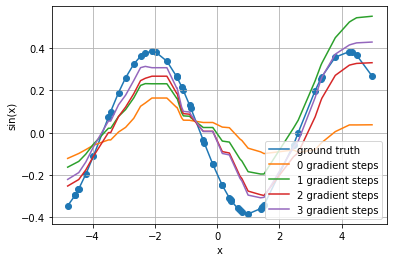

In [ ]:
wave = SinWave()
x, y = wave.test_values()
item= sorted(zip(x, y), key=lambda x: x[0], reverse=False)
x_test = []
y_test = []

for i in item:
    x_test.append(i[0])
    y_test.append(i[1])

plot_graph(x_test, y_test, label = 'ground truth')

for n_inner_ in np.arange(4):
    new_model = train_inner(model, wave, k_steps=n_inner_, lr=0.01)
    x = torch.tensor(x_test, dtype= torch.float32, device=device).unsqueeze(-1)
    y_pred = new_model(x).detach().numpy()
    plot_graph(x_test, y_pred, label = f'{n_inner_} gradient steps')

plt.legend()   
plt.show()